# Python для DataScience
## Курсовая работа

В этой курсовой работе мы будем обучать модель, предсказывающую цены на квартиры

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### Загрузка данных

Скачаем датасеты:

In [2]:
from urllib import request
from os.path import isfile

train_url = 'https://uploads.hb.cldmail.ru/asset/1381522/attachment/302b3d11658ce764f4e8655292566e11.csv'
test_url = 'https://uploads.hb.cldmail.ru/asset/1381521/attachment/f74867a92dc85932950369d8d31db3b0.csv'

train_path = 'train.csv'
test_path = 'test.csv'

if not isfile(train_path):
    request.urlretrieve(train_url, train_path)
if not isfile(test_path):
    request.urlretrieve(test_url, test_path)

In [3]:
data = pd.read_csv(train_path)


### Очистка данных
Давайте проанализируем датасет

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


In [5]:
data.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


Мы видим ряд результатов, давайте определим ряд заявлений:

#### 25% данных о размерах кухни составляют 1, что не похоже на правду. 
Если это так, то данным признаком следует пренебречь, так как он крайне неточен

Для начала, построим гистограмму распределения квартир по площадям кухни

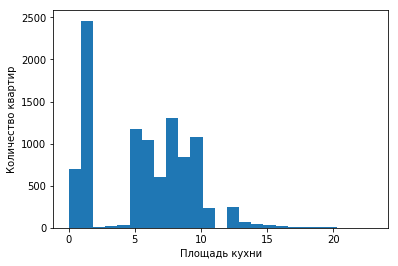

In [6]:
plt.hist(
    data['KitchenSquare'].loc[data.KitchenSquare < 25], 
    bins=25
)

plt.xlabel('Площадь кухни')
plt.ylabel('Количество квартир')
plt.show();

Давайте вычислим среднюю площадь квартиры, имеющую кухню площадью 1, а также общий процент таких квартир среди всей выборки

In [7]:
square_with_tiny_kitchen = data.loc[data.KitchenSquare <= 1]['Square'].loc[data.Square < 100]

In [8]:
square_with_tiny_kitchen.mean(), square_with_tiny_kitchen.count() / data['Square'].count()

(57.808910788199775, 0.3045)

Выходит, что 30% квартир имеют площадь кухни 1 и менее, при том что средняя площать среди них 57. Можно было бы объяснить отсутсвие кухонь в случае если объект является общежитием или апартаментами, но не с такой средней площадью. Из этого можно заключить что признак `KitchenSquare` невалиден и должен быть исключен из выборки.

#### 48% записей не имеют значения в признаке  `Healthcare_1`. 
Если этот признак не кореллирует с другими параметрами то его можно исключить из выборки.

Давайте возьмем все непустые значения и оценим

In [24]:
Healthcare_1_mean = data['Healthcare_1'].mean()
data['Healthcare_1'].fillna(Healthcare_1_mean, inplace=Trueue)

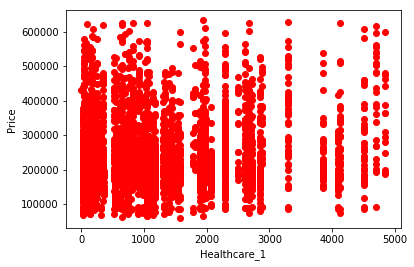

In [25]:
plt.plot(
    health_param_1['Healthcare_1'],
    health_param_1['Price'],
    'ro'
)
plt.xlabel('Healthcare_1')
plt.ylabel('Price')
plt.show();

In [22]:
health_param_1[['Healthcare_1', 'Helthcare_2', 'Price']].corr()

,Healthcare_1,Helthcare_2,Price
Healthcare_1,1.000000,0.203177,0.138755
Helthcare_2,0.203177,1.000000,0.135872
Price,0.138755,0.135872,1.000000


In [23]:
health_param_1.corr()['Healthcare_1']

Id              -0.003879
DistrictId       0.304335
Rooms            0.042857
Square          -0.039748
LifeSquare      -0.026867
KitchenSquare    0.009472
Floor           -0.138294
HouseFloor      -0.143973
HouseYear       -0.011969
Ecology_1       -0.043547
Social_1         0.077133
Social_2         0.050458
Social_3         0.133877
Healthcare_1     1.000000
Helthcare_2      0.203177
Shops_1          0.057758
Price            0.138755
Name: Healthcare_1, dtype: float64

Выходит, что признак 'Healthcare_1' не кореллирует с остальными, и поскольку заполнен лишь на 50% то он также невалиден и им можно принебречь

#### Оценим признак `Rooms`

In [342]:
data['Rooms'].describe()

count    10000.000000
mean         1.890500
std          0.839512
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         19.000000
Name: Rooms, dtype: float64

In [343]:
data['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

Заменим выбросы ( rooms == 0 ) и ( rooms > 5 ) на среднее значение по выборке

In [38]:
rooms_mean = data.Rooms.mean()
data[data.Rooms > 5] = rooms_mean
data[data.Rooms < 1] = rooms_mean

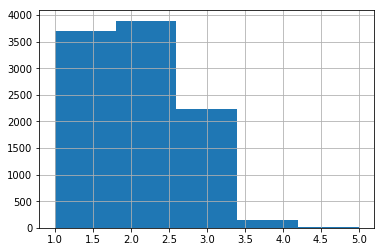

In [39]:
data.Rooms.hist(bins=5)

#### Оценим признак `LifeSquare`
Найдем те записи, где `LifeSquare` > `Square`

In [40]:
data[data.LifeSquare > data.Square].shape[0]

482

Выходит, что для 4% записей жилая площадь больше общей площади, что некорректно. Давайте оценим зависимость площадей.

(10, 250)

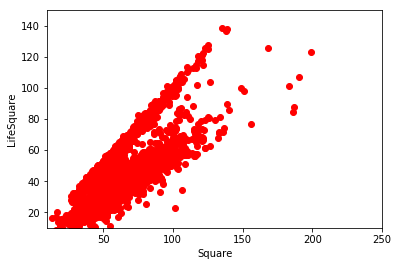

In [41]:
plt.plot(
    data['Square'],
    data['LifeSquare'],
    'ro'
)
plt.xlabel('Square')
plt.ylabel('LifeSquare')
plt.ylim(10,150)
plt.xlim(10,250)

Видно, что зависимость линейна. Предлагаю признак `LifeSquare` также не включать в итоговый датасет

#### Оценим признак `Square`

In [42]:
data['Square'].describe()

count    10000.000000
mean        56.230610
std         21.056030
min          1.136859
25%         41.751942
50%         52.482304
75%         65.889256
max        641.065193
Name: Square, dtype: float64

In [43]:
bad_square = data[data.Square < 10]
bad_square.shape[0]

23

А давайте их выкинем :)

In [44]:
data.drop(bad_square.index, inplace=True)

#### Оценим признак `HouseYear`

In [45]:
data['HouseYear'].value_counts()

1977.0        2640
2017.0         308
2016.0         303
2015.0         298
2014.0         208
1970.0         194
1969.0         189
1972.0         178
1971.0         177
2018.0         175
1974.0         169
1968.0         162
1965.0         161
1963.0         158
1976.0         155
1973.0         150
1975.0         150
1964.0         150
1967.0         146
1966.0         140
1978.0         129
1962.0         125
1960.0         121
1961.0         113
1982.0         110
1981.0         108
1979.0         107
1980.0         107
2005.0         102
1983.0         101
              ... 
1952.0          10
1953.0          10
1950.0           7
1935.0           7
1931.0           7
1939.0           6
1933.0           5
1918.0           5
1937.0           5
1940.0           4
1951.0           4
1934.0           4
1938.0           4
1942.0           3
1919.0           3
1930.0           3
1917.0           3
1936.0           3
1941.0           2
1932.0           2
1912.0           2
1929.0      

Видим явно выпадающие значения [4968, 20052011]

Заменим 4968 на 1968, 20052011 на 2008

In [46]:
data.loc[data.HouseYear == 4968, 'HouseYear'] = 1968
data.loc[data.HouseYear == 20052011, 'HouseYear'] = 2008

Ради интереса, построим гистограмму

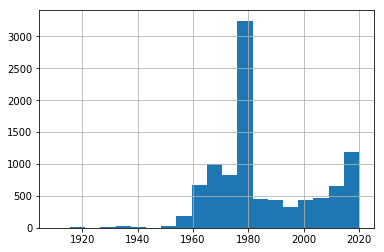

In [47]:
data['HouseYear'].hist(bins=20);

Примечательно - большинство квартир в домах построенных на рубеже конца 1970х - начала 1980х

#### Оценим признак `DistrictId`
Начнем с гистограммы

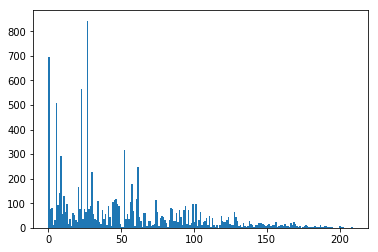

In [48]:
plt.hist(
    data['DistrictId'],
    bins=data['DistrictId'].nunique()
);

Это ничего не дало. Попробуем взять среднюю цену за квадратный метр по району

In [49]:
data['price_per_square'] = data.Price / data.Square

In [50]:
price_per_square_by_District = data.groupby(['DistrictId'])['price_per_square'].mean().reset_index().rename(columns={'price_per_square': 'District_square_price'})

In [51]:
price_per_square_by_District.head(5)

,DistrictId,District_square_price
0,0.0,3710.401014
1,1.0,3214.409087
2,2.0,4560.204511
3,3.0,3783.790553
4,4.0,5247.142313


Доавим признак `District_square_price` к датасету

In [52]:
def add_distr_sq_price(df,price_per_square_by_District):
    # Среднее значение цена по всем районам
    dqp_mean = price_per_square_by_District['District_square_price'].mean()
    
    df=pd.merge(df,price_per_square_by_District,on='DistrictId',how='left')
    df['District_square_price']=df['District_square_price'].fillna(dqp_mean)
    return df

In [53]:
data = add_distr_sq_price(data, price_per_square_by_District).drop(
    ['price_per_square','DistrictId'], axis=1)

In [54]:
data.head(3)

,Id,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,District_square_price
0,14038.0,2.0,47.981561,29.442751,6.0,7.0,9.0,1969.0,0.089040,B,B,33.0,7976.0,5.0,1142.90446,0.0,11.0,B,184966.930730,4384.628620
1,15053.0,3.0,65.683640,40.049543,8.0,7.0,9.0,1978.0,0.000070,B,B,46.0,10309.0,1.0,240.00000,1.0,16.0,B,300009.450063,4293.480295
2,4765.0,2.0,44.947953,29.197612,0.0,8.0,12.0,1968.0,0.049637,B,B,34.0,7759.0,0.0,229.00000,1.0,3.0,B,220925.908524,4835.401165


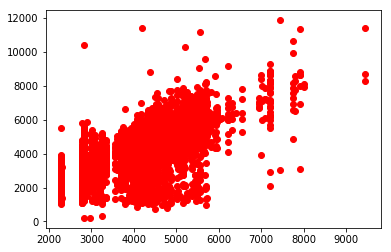

In [55]:
plt.plot(
    data['District_square_price'],
    data['Price'] / data['Square'],
    'ro'
)

#### Оценим признак `Shops_2`

In [56]:
data['Shops_2'].value_counts()

B    9152
A     825
Name: Shops_2, dtype: int64

Оставим как есть

#### Оценим признаки `Floor` `HouseFloor`
Очистим выпадающие записи

In [57]:
floor_data = data[['Floor','HouseFloor']]
floor_data['HouseFloor'].value_counts()

17.0     2328
9.0      1388
12.0     1074
5.0      1031
14.0      625
16.0      575
1.0       492
25.0      373
22.0      341
0.0       265
24.0      176
8.0       141
10.0      135
4.0       133
3.0       125
15.0      122
19.0      107
20.0      105
18.0       89
7.0        59
6.0        58
2.0        47
23.0       40
21.0       33
11.0       28
13.0       27
30.0       21
40.0        7
27.0        6
37.0        4
32.0        4
28.0        3
48.0        2
99.0        2
39.0        2
117.0       1
29.0        1
31.0        1
38.0        1
44.0        1
36.0        1
26.0        1
45.0        1
47.0        1
Name: HouseFloor, dtype: int64

Давайте посмотрим на дома выше 30 этажей

In [58]:
data['is_first_floor'] = (data.Floor == 1).astype(int)
data['is_last_floor'] = (data.Floor >= data.HouseFloor).astype(int)

### Обучение моделей и их применение

#### Разбиение на тренировочные и тестовые

In [59]:
ds = pd.get_dummies(data).drop(
    #['LifeSquare', 'KitchenSquare', 'Healthcare_1', 'Floor', 'HouseFloor'], 
    ['LifeSquare', 'KitchenSquare'],
    axis=1
).set_index('Id')

In [60]:
X_train, X_test, y_train, y_test = train_test_split(
    ds.drop(['Price'], axis=1), 
    ds['Price'], 
    test_size=0.2, random_state=42
)

Стандартизируем значения:

In [61]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.keys())
X_test_scaled = pd.DataFrame(
    scaler.fit_transform(X_test),
    columns=X_test.keys())

In [62]:
def get_model_r2(X_train, y_train, X_test, y_test, model):
    model.fit(X_train, y_train)
    y_pred=model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    return r2

#### Линейная регрессия

In [63]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
get_model_r2(X_train_scaled, y_train, X_test_scaled, y_test, lr)

0.6746181439369701

#### Примение T-SNE
Попробуем перебрать параметр `learning_rates` чтобы найти идеальные условия для кластеризации

In [64]:
from sklearn.manifold import TSNE
from multiprocessing import Pool

In [65]:
def train_tsne(lr):
    tsne = TSNE(n_components=2, learning_rate=lr, random_state=42)
    return tsne.fit_transform(X_train_scaled)

def get_good_tsne():
    learning_rates = [10, 50, 100, 150, 300, 500, 800, 1000]
    tsne_list = dict()
    with Pool() as p:  
        tsne_list = p.map(train_tsne, learning_rates)
    return dict(zip(learning_rates, tsne_list))

In [66]:
tsne_dict = get_good_tsne()

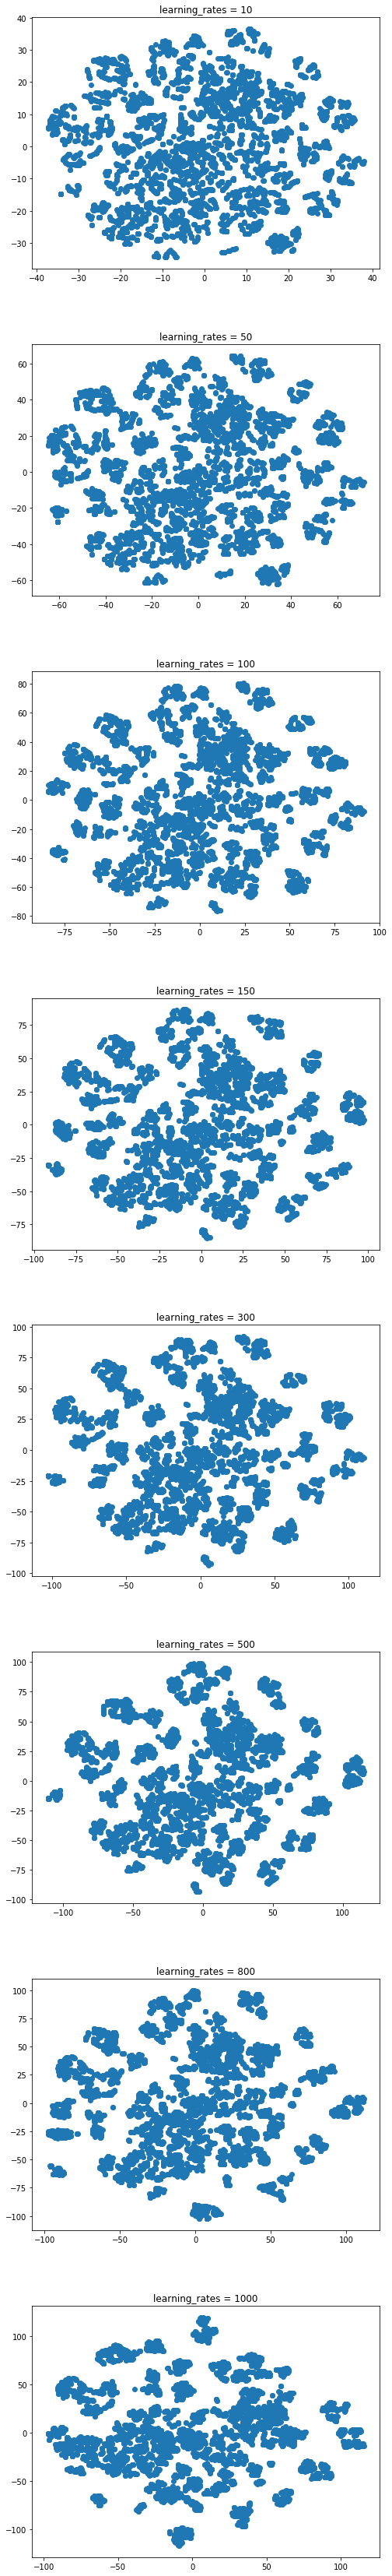

In [67]:
fig, ax = plt.subplots(len(tsne_dict),1)
fig.set_figwidth(8)
fig.set_figheight(60)
fig.subplots_adjust(wspace=0.3, hspace=0.3)

i = 0
for lr, tsne_array in tsne_dict.items():
    ax[i].scatter(tsne_array[:, 0], tsne_array[:, 1])
    ax[i].set_title(f'learning_rates = {lr}')
    i += 1

По полученным графиком я не вижу явной возможности для кластеризации, так что исключим подобные алгоритмы.

Но давайте попробуем разбить на 3 кластера:

In [68]:
from sklearn.cluster import KMeans

In [69]:
kmeans = KMeans(n_clusters=3)
labels_train = kmeans.fit_predict(X_train_scaled)
pd.value_counts(labels_train)

1    4704
0    2621
2     656
dtype: int64

In [70]:
labels_train = kmeans.predict(X_train_scaled)

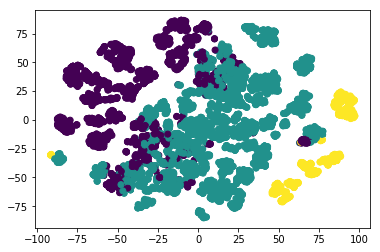

In [71]:
plt.scatter(
    tsne_dict[150][:, 0],
    tsne_dict[150][:, 1],
    c=labels_train
);

Так себе разбиение на кластеры, если честно

#### PCA (Метод главных компонент)
Попробуем выявить наиболее значимые признаки

In [72]:
from sklearn.decomposition import PCA


In [73]:
print("Оценка линейной регрессии при разном количестве взятых признаков:")
for n in range(1,X_train.shape[1] + 1):
    pca = PCA(n_components=n, random_state=42)
    X_train_mc = pca.fit_transform(X_train_scaled)
    X_test_mc = pca.transform(X_test_scaled)
    lr = LinearRegression()
    r2 = get_model_r2(X_train_mc, y_train, X_test_mc, y_test, lr)
    
    print(f'при n = {n}, \t r2 = {r2:.4f},\tacc = {np.sum(pca.explained_variance_ratio_[:n])}')

Оценка линейной регрессии при разном количестве взятых признаков:
при n = 1, 	 r2 = 0.1304,	acc = 0.16568513731892137
при n = 2, 	 r2 = 0.1649,	acc = 0.27188067604397204
при n = 3, 	 r2 = 0.1645,	acc = 0.37240758167679394
при n = 4, 	 r2 = 0.2520,	acc = 0.4619406216812305
при n = 5, 	 r2 = 0.2961,	acc = 0.548752085569364
при n = 6, 	 r2 = 0.4917,	acc = 0.6268306437034672
при n = 7, 	 r2 = 0.5174,	acc = 0.6927179782417112
при n = 8, 	 r2 = 0.5197,	acc = 0.7536221894092594
при n = 9, 	 r2 = 0.5606,	acc = 0.8031769186174507
при n = 10, 	 r2 = 0.5608,	acc = 0.8447963454924644
при n = 11, 	 r2 = 0.5624,	acc = 0.8838136786786102
при n = 12, 	 r2 = 0.5835,	acc = 0.9172573722446833
при n = 13, 	 r2 = 0.6107,	acc = 0.9438843401469239
при n = 14, 	 r2 = 0.6713,	acc = 0.9662268752012511
при n = 15, 	 r2 = 0.6741,	acc = 0.9791501910036615
при n = 16, 	 r2 = 0.6748,	acc = 0.9902091437393512
при n = 17, 	 r2 = 0.6749,	acc = 0.9983857197345812
при n = 18, 	 r2 = 0.6749,	acc = 1.0000000000000002
при n

Мы видим что лучший результат достигается при $n = 17$

In [74]:
pca = PCA(n_components=17, random_state=42)

X_train_mc = pca.fit_transform(X_train_scaled)

X_test_mc = pca.transform(X_test_scaled)

get_model_r2(X_train_mc, y_train, X_test_mc, y_test, lr)

0.6748682801463531

#### Дерево решений

In [75]:
from sklearn.tree import DecisionTreeRegressor

In [76]:
def do_tree(max_depth):
    model = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
    return get_model_r2(X_train_mc, y_train, X_test_mc, y_test, model)
    
def best_tree_score():
    max_depths = np.arange(2,20)
    with Pool() as p:  
        tree_score_list = p.map(do_tree, max_depths)
    return dict(zip(max_depths, tree_score_list))

In [77]:
tree_dict = best_tree_score()

In [78]:
print("Оценка дерева решений с переменной глубиной ")
for depth, r2 in tree_dict.items():
    print(f'max_depth: {depth} \t r2: {r2:.4f}')

Оценка дерева решений с переменной глубиной 
max_depth: 2 	 r2: 0.3217
max_depth: 3 	 r2: 0.4078
max_depth: 4 	 r2: 0.4583
max_depth: 5 	 r2: 0.5126
max_depth: 6 	 r2: 0.5400
max_depth: 7 	 r2: 0.5353
max_depth: 8 	 r2: 0.5523
max_depth: 9 	 r2: 0.5389
max_depth: 10 	 r2: 0.5034
max_depth: 11 	 r2: 0.4945
max_depth: 12 	 r2: 0.4594
max_depth: 13 	 r2: 0.4513
max_depth: 14 	 r2: 0.4065
max_depth: 15 	 r2: 0.4146
max_depth: 16 	 r2: 0.4036
max_depth: 17 	 r2: 0.3869
max_depth: 18 	 r2: 0.3833
max_depth: 19 	 r2: 0.3780


При вычислении регресси деревом решений глубины 6 мы получаем точность $r2 = 0.54$

#### Случайный лес

In [79]:
from sklearn.ensemble import RandomForestRegressor

In [84]:
def do_forest(max_depth):
    model = RandomForestRegressor(n_estimators=1000, max_depth=max_depth, random_state=42)
    return get_model_r2(X_train_mc, y_train, X_test_mc, y_test, model)
    
def best_forest_score():
    max_depths = np.arange(15,32)
    with Pool() as p:  
        forest_score_list = p.map(do_forest, max_depths)
    return dict(zip(max_depths, forest_score_list))

In [81]:
do_forest(16)

0.7063428386760808

In [85]:
forest_dict = best_forest_score()

In [86]:
print("Оценка случайных деревьев с переменной глубиной ")
for depth, r2 in forest_dict.items():
    print(f'max_depth: {depth} \t r2: {r2:.4f}')

Оценка случайных деревьев с переменной глубиной 
max_depth: 15 	 r2: 0.7060
max_depth: 16 	 r2: 0.7063
max_depth: 17 	 r2: 0.7064
max_depth: 18 	 r2: 0.7067
max_depth: 19 	 r2: 0.7070
max_depth: 20 	 r2: 0.7070
max_depth: 21 	 r2: 0.7064
max_depth: 22 	 r2: 0.7070
max_depth: 23 	 r2: 0.7072
max_depth: 24 	 r2: 0.7065
max_depth: 25 	 r2: 0.7070
max_depth: 26 	 r2: 0.7066
max_depth: 27 	 r2: 0.7069
max_depth: 28 	 r2: 0.7066
max_depth: 29 	 r2: 0.7067
max_depth: 30 	 r2: 0.7064
max_depth: 31 	 r2: 0.7066


При вычислении регрессии случайным лесом глубиной 23 мы получаем точность $r2 = 0.7072$

#### Расширенный случайный лес
будем использовать также `GredSearchCV`

In [550]:
from sklearn.model_selection import GridSearchCV

In [580]:
parametrs = [{'n_estimators': [150,200,250,500,750,1000],
              'max_features': ["auto", "sqrt", "log2"],
              'max_depth': np.arange(5,20)}]

In [581]:
clf = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                   param_grid=parametrs,
                   scoring='r2',
                   n_jobs=-1,
                   cv=5)

In [ ]:
clf.fit(X_train_mc, y_train)

In [ ]:
clf.best_params_, clf.best_score_

In [578]:
clf.best_params_

{'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 250}

In [579]:
clf.best_score_

0.7121717789264065